# A Python Tour of Data Science: High Performance Computing

[Michaël Defferrard](http://deff.ch), *PhD student*, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

# Exercise: is Python slow ?

That is one of the most heard complain about Python. Because [CPython](https://en.wikipedia.org/wiki/CPython), the Python reference implementation, [interprets the language](https://en.wikipedia.org/wiki/Interpreted_language) (i.e. it compiles Python code to intermediate bytecode which is then interpreted by a virtual machine), it is inherentably slower than [compiled languages](https://en.wikipedia.org/wiki/Compiled_language), especially for computation heavy tasks such as number crunching.

There are three ways around it that we'll explore in this exercise:
1. Specialized libraries.
1. Compile Python to machine code.
1. Implement in a compiled language and call from Python.

In this exercise we'll compare many possible implementations of a function. Our goal is to compare the execution time of our implementations and get a sense of the many ways to write efficient Python code. We test seven implementations:

Along the exercise we'll use the function
$$accuracy(\hat{y}, y) = \frac1n \sum_{i=0}^{i=n-1} 1(\hat{y}_i = y_i),$$
where $1(x)$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) and $n$ is the number of samples. This function computes the accuracy, i.e. the percentage of correct predictions, of a classifier. A pure Python implementation is given below.

In [1]:
def accuracy_python(y_pred, y_true):
    """Plain Python implementation."""
    num_correct = 0
    for y_pred_i, y_true_i in zip(y_pred, y_true):
        if y_pred_i == y_true_i:
            num_correct += 1
    return num_correct / len(y_true)

Below we test and measure the execution time of the above implementation. The [%timeit](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=timeit#magic-timeit) function provided by IPython is a useful helper to measure the execution time of a line of Python code. As we'll see, the above implementation is very inefficient compared to what we can achieve.

In [2]:
import numpy as np

c = 10  # Number of classes.
n = int(1e6)  # Number of samples.

y_true = np.random.randint(0, c, size=n)
y_pred = np.random.randint(0, c, size=n)
print('Expected accuracy: {}'.format(1/c))
print('Empirical accuracy: {}'.format(accuracy_python(y_pred, y_true)))

%timeit accuracy_python(y_pred, y_true)

Expected accuracy: 0.1
Empirical accuracy: 0.099648
10 loops, best of 3: 156 ms per loop


# 1 Specialized libraries

Specialized libraries, which provide efficient compiled implementations of the heavy computations, is an easy way to solve the performance problem. That is for example NumPy, which uses efficient BLAS and LAPACK implementations as a backend. SciPy and scikit-learn fall in the same category.

Implement below the accuracy function using:
1. Only functions provided by [NumPy](http://www.numpy.org/). The idea here is to *vectorize* the computation.
2. The implementation of [scikit-learn](http://scikit-learn.org/), our machine learning library.

Then test that it provides the correct result and measure it's execution time. How much faster are they compared to the pure Python implementation ?

In [3]:
def accuracy_numpy(y_pred, y_true):
    """Numpy implementation."""
    return np.sum(y_pred == y_true) / y_true.size

def accuracy_sklearn(y_pred, y_true):
    """Scikit-learn implementation."""
    from sklearn import metrics
    return metrics.accuracy_score(y_pred, y_true)

assert np.allclose(accuracy_numpy(y_pred, y_true), accuracy_python(y_pred, y_true))
assert np.allclose(accuracy_sklearn(y_pred, y_true), accuracy_python(y_pred, y_true))

%timeit accuracy_numpy(y_pred, y_true)
%timeit accuracy_sklearn(y_pred, y_true)

100 loops, best of 3: 2.23 ms per loop
10 loops, best of 3: 52 ms per loop


# 2 Compiled Python

The second option of choice, when the algorirthm does not exist in our favorite libraries and we have to implement it, it to implement in Python and compile it to machine code.

Below you'll compile Python with two frameworks.
1. [Numba](http://numba.pydata.org) is a [just-in-time (JIT)](https://en.wikipedia.org/wiki/Just-in-time_compilation) compiler for Python, using the [LLVM](http://llvm.org) compiler infrastructure.
1. [Cython](http://cython.org), which requires type information, [transpiles](https://en.wikipedia.org/wiki/Source-to-source_compiler) Python to C then compiles the generated C code.

While these two approaches offer maximal compatibility with the CPython and NumPy ecosystems, another approach is to use another Python implementation such as [PyPy](http://pypy.org), which features a just-in-time compiler and supports multiple back-ends (C, CLI, JVM). Alternatives are [Jython](http://www.jython.org), which runs Python on the Java platform, and [IronPython](http://ironpython.net) / [PythonNet](http://pythonnet.github.io) for the .NET platform.

In [4]:
from numba import jit
# Decorator, same as accuracy_numba = jit(accuracy_python)

@jit
def accuracy_numba(y_pred, y_true):
    """Plain Python implementation, compiled by LLVM through Numba."""
    num_correct = 0
    for y_pred_i, y_true_i in zip(y_pred, y_true):
        if y_pred_i == y_true_i:
            num_correct += 1
    return num_correct / len(y_true)

In [5]:
%load_ext Cython

/usr/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


In [6]:
%%cython
cimport numpy as np
cimport cython

@cython.boundscheck(False)  # Turn off bounds-checking for entire function.
@cython.wraparound(False)   # Turn off negative index wrapping for entire function.
def accuracy_cython(np.ndarray[long, ndim=1] y_pred, np.ndarray[long, ndim=1] y_true):
    """Python implementation with type information, transpiled to C by Cython."""
    cdef int num_total = len(y_true)
    cdef int num_correct = 0
    cdef int n = y_pred.size
    for i in range(n):
        if y_pred[i] == y_true[i]:
            num_correct += 1
    return num_correct / num_total

Evaluate below the performance of those two implementations, while testing their correctness. How do they compare with plain Python and specialized libraries ?

In [7]:
assert np.allclose(accuracy_numba(y_pred, y_true), accuracy_python(y_pred, y_true))
assert np.allclose(accuracy_cython(y_pred, y_true), accuracy_python(y_pred, y_true))

%timeit accuracy_numba(y_pred, y_true)
%timeit accuracy_cython(y_pred, y_true)

1000 loops, best of 3: 1.17 ms per loop
1000 loops, best of 3: 1.07 ms per loop


# 3 Using C from Python

Here we'll explore our third option to make Python faster: implement in another language ! Below you'll
1. implement the accuracy function in C,
1. compile it, e.g. with the GNU compiler collection ([GCC](https://gcc.gnu.org/)),
1. call it from Python.

In [8]:
%%file function.c

double accuracy(long* y_pred, long* y_true, int n) {
    int num_correct = 0;

    for(int i = 0; i < n; i++) {
        if(y_pred[i] == y_true[i])
            num_correct++;
    }

    return (double) num_correct / n;
}

Overwriting function.c


The below cell describe a shell script, which will be executed by IPython as if you typed the commands in your terminal. Those commands are compiling the above C program into a dynamic library with GCC. You can use any other compiler, text editor or IDE to produce the C library. Windows users, you may want to use Microsoft toolchain.

In [9]:
%%script sh
FILE=function
gcc -c -O3 -Wall -std=c11 -pedantic -fPIC -o $FILE.o $FILE.c
gcc -o lib$FILE.so -shared $FILE.o
file lib$FILE.so

libfunction.so: ELF 64-bit LSB shared object, x86-64, version 1 (SYSV), dynamically linked, BuildID[sha1]=23d5e34e0dcd19e3a614dde9fdb3295247b59527, not stripped


The below cell finally create a wrapper around our C library so that we can easily use it from Python.

In [10]:
import ctypes

libfunction = np.ctypeslib.load_library('libfunction', './')
libfunction.accuracy.restype = ctypes.c_double
libfunction.accuracy.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.int),
    np.ctypeslib.ndpointer(dtype=np.int),
    ctypes.c_int
]

def accuracy_c(y_pred, y_true):
    n = y_pred.size
    return libfunction.accuracy(y_pred, y_true, n)

Evaluate below the performance of your C implementation, and test its correctness. How does it compare with the others ?

In [11]:
assert np.allclose(accuracy_c(y_pred, y_true), accuracy_python(y_pred, y_true))
%timeit accuracy_c(y_pred, y_true)

1000 loops, best of 3: 1.1 ms per loop


# 4 Using Fortran from Python

Same idea as before, with Fortran ! [Fortran](https://en.wikipedia.org/wiki/Fortran) is an imperative programming language developed in the 50s, especially suited to numeric computation and scientific computing. While you probably won't write new code in Fortran, you may have to interface with legacy code (especially in large and old corporations). Here we'll resort to the [f2py](https://docs.scipy.org/doc/numpy-dev/f2py/) utility provided by the Numpy project for the (almost automatic) generation of a wrapper.

In [12]:
%%file function.f

! The content of this cell is written to the "function.f" file in the current directory.

      SUBROUTINE DACCURACY(YPRED, YTRUE, ACC, N)

CF2PY INTENT(OUT) :: ACC
CF2PY INTENT(HIDE) :: N
      INTEGER*4 YPRED(N)
      INTEGER*4 YTRUE(N)
      DOUBLE PRECISION ACC
      INTEGER N, NCORRECT

      NCORRECT = 0

      DO 10 J = 1, N
         IF (YPRED(J) == YTRUE(J)) THEN
            NCORRECT = NCORRECT + 1
         END IF
 10   CONTINUE

      ACC = REAL(NCORRECT) / N
      END

Overwriting function.f


The below command compile the Fortran code and generate a Python wrapper.

In [13]:
!f2py -c -m function function.f >> /dev/null

In [14]:
import function
def accuracy_fortran(y_pred, y_true):
    return function.daccuracy(y_pred, y_true)

Evaluate below the performance of your Fortran implementation, and test its correctness. How does it compare with the others ?

In [15]:
assert np.allclose(accuracy_fortran(y_pred, y_true), accuracy_python(y_pred, y_true))
%timeit accuracy_fortran(y_pred, y_true)

100 loops, best of 3: 2.12 ms per loop


# 5 Analysis

Plot a graph with `n` as the x-axis and the execution time of the various methods on the y-axis. 

In [16]:
%%capture
# Suppress outputs.

N = 8  # Number of samples: from 1 to 10^N.

methods = ['accuracy_python', 'accuracy_sklearn', 'accuracy_fortran', 'accuracy_numpy',
           'accuracy_numba', 'accuracy_cython', 'accuracy_c']

times = np.empty((len(methods), N+1))
for n in range(0, N+1):
    y_true = np.random.randint(2, size=10**n)
    y_pred = np.random.randint(2, size=len(y_true))
    for i, method in enumerate(methods):
        res = %timeit -o eval(method)(y_pred, y_true)
        times[i, n] = res.best

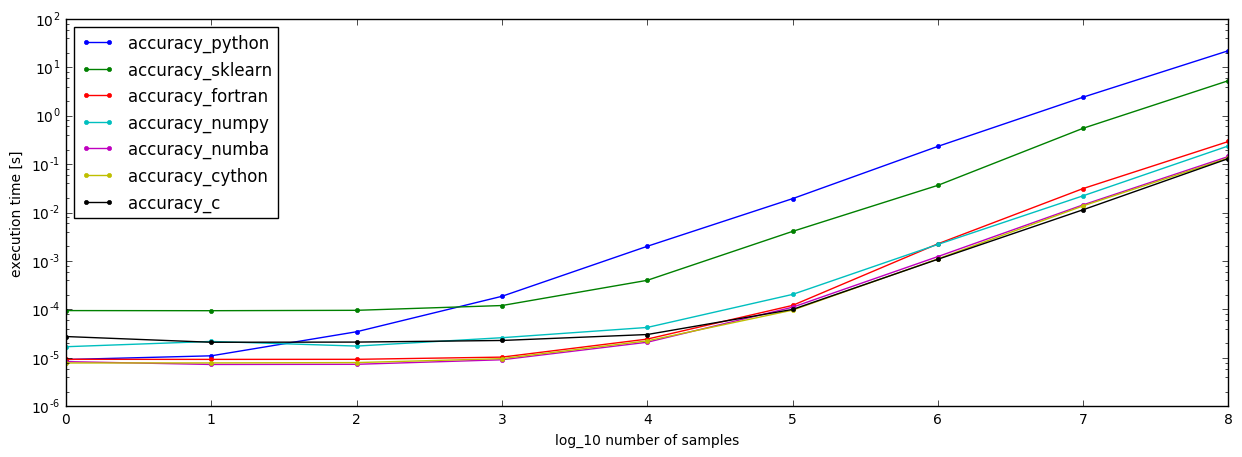

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15, 5))
for i, method in enumerate(methods):
    plt.semilogy(range(N+1), times[i,:], '.-', label=method)
plt.legend(loc='upper left')
plt.ylabel('execution time [s]')
plt.xlabel('log_10 number of samples')
plt.xticks(range(N+1))
plt.show();

To reflect on what we've done, answer the following questions:
1. Which implementation is the fastest ?
1. Which solution was the easiest to work with ?
1. Which solution would you use in which situation ?

It turns out the compiled versions by Numba and Cython are almost as fast as C ! Although much easier to write. In this case, they are even faster than Fortran, NumPy and scikit-learn. This gives us the best of both worlds: an interpreted language for rapid development, which can then be compiled for efficient execution in production.